# BSplineTrajectory Evaluation
This notebook evaluates the following 3 hand-crafted trajectories. The 8 range sensors are equally spanned out to cover a field of fiew of 120 degrees (shown in the following screenshot is 40 degrees).
![Trajectories](https://dl.dropboxusercontent.com/u/17489929/Studium/Jobs/RESL/SMAP/smap_trajectories.png)

First, we analyze the trajectories (given the time profile from below) and [evaluate different cost functions](#Cost-Function-$\mu-\cdot-\sigma$) (totally experimental).
This notebook also [computes the velocity profiles](#Velocity-&-Time-Profiles) (timing information) for these splines.

In [675]:
%matplotlib inline
# Load bag files
import matplotlib.pyplot as plt
import sys, rospy, rosbag, os, math
import numpy as np

splines = []

for _, _, files in os.walk("splines"):
    for file in files:
        bag = rosbag.Bag("splines/" + file)
        for topic, msg, t in bag.read_messages(topics=['stats']):
            msg.trajectoryT = list(msg.trajectoryT[:])
            was_zero = False
            for i in range(len(msg.trajectoryT)):
                if msg.trajectoryT[i] >= 2.5:
                    was_zero = True
                elif msg.trajectoryT[i] < 0 and was_zero:
                    msg.trajectoryT[i] += 2*math.pi
                
            splines.append(msg)
        bag.close()
        print("Loaded ROS bag file from %s." % file)

Loaded ROS bag file from spline_0.bag.
Loaded ROS bag file from spline_1.bag.
Loaded ROS bag file from spline_2.bag.


# Local Reachability
In the following, we evaluate at every time step $t_i$ the upcoming voxels where we would be in the next timesteps $t_{i+1}, t_{i+2}, ..., t_{i+k}$ until the timespan $\Delta_t$, i.e. $t_{i+k}-t_i \leq \Delta_t$ (here 1.5 time units). For every such voxel, we also analyze the surrounding voxels (radius of 0.5 voxel sizes).

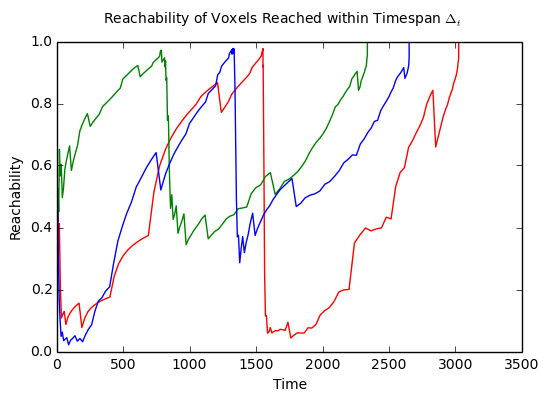

In [676]:
%matplotlib inline
colors = ["r", "g", "b"]
ax = plt.subplot(111)
plt.suptitle("Reachability of Voxels Reached within Timespan $\Delta_t$")
ax.set_xlabel("Time")
ax.set_ylabel("Reachability")
for i, spline in enumerate(splines):
    ax.plot(spline.trajectoryTime, spline.trajectoryFutureReachability, label=beliefName, c=colors[i%len(colors)])

For a field of view of 120 degrees, the green spline has the best local reachability. The red trajectory makes movements where for the next few voxels it is highly uncertain whether they are reachable.

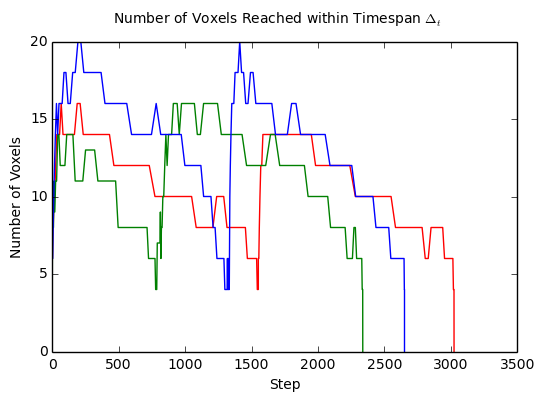

In [677]:
%matplotlib inline
ax = plt.subplot(111)
plt.suptitle("Number of Voxels Reached within Timespan $\Delta_t$")
ax.set_xlabel("Step")
ax.set_ylabel("Number of Voxels")
for i, spline in enumerate(splines):
    ax.plot(spline.trajectoryTime, spline.trajectoryFutureVoxels, label=beliefName, c=colors[i%len(colors)])

# MAE Evolution (All Voxels)

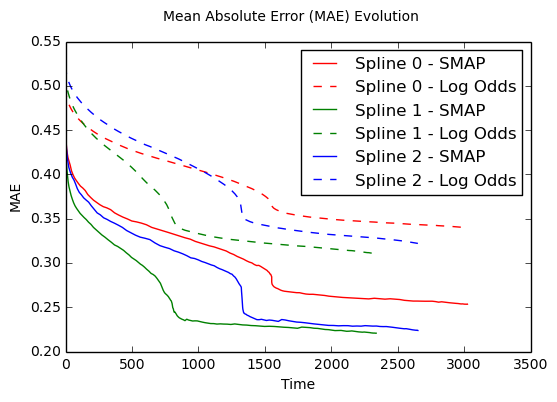

In [678]:
%matplotlib inline
plt.suptitle("Mean Absolute Error (MAE) Evolution")
ax = plt.subplot(111)
ax.set_xlabel("Time")
ax.set_ylabel("MAE")
for i, spline in enumerate(splines):
    beliefName = 'Spline {} - SMAP'.format(i)
    logOddsName = 'Spline {} - Log Odds'.format(i)
    ax.plot(spline.trajectoryTime, spline.errorEvolutionBelief, label=beliefName, c=colors[i%len(colors)])
    ax.plot(spline.trajectoryTime, spline.errorEvolutionLogOdds, label=logOddsName, linestyle='dashed', c=colors[i%len(colors)])
ax.legend()

# Global Reachability Evolution
Reachability, voxel mean (estimated occupancy) and voxel std dev (SMAP-esimated) evaluated over _all_ voxels along the trajectory (in contrast to above, here we don't consider surrounding voxels).

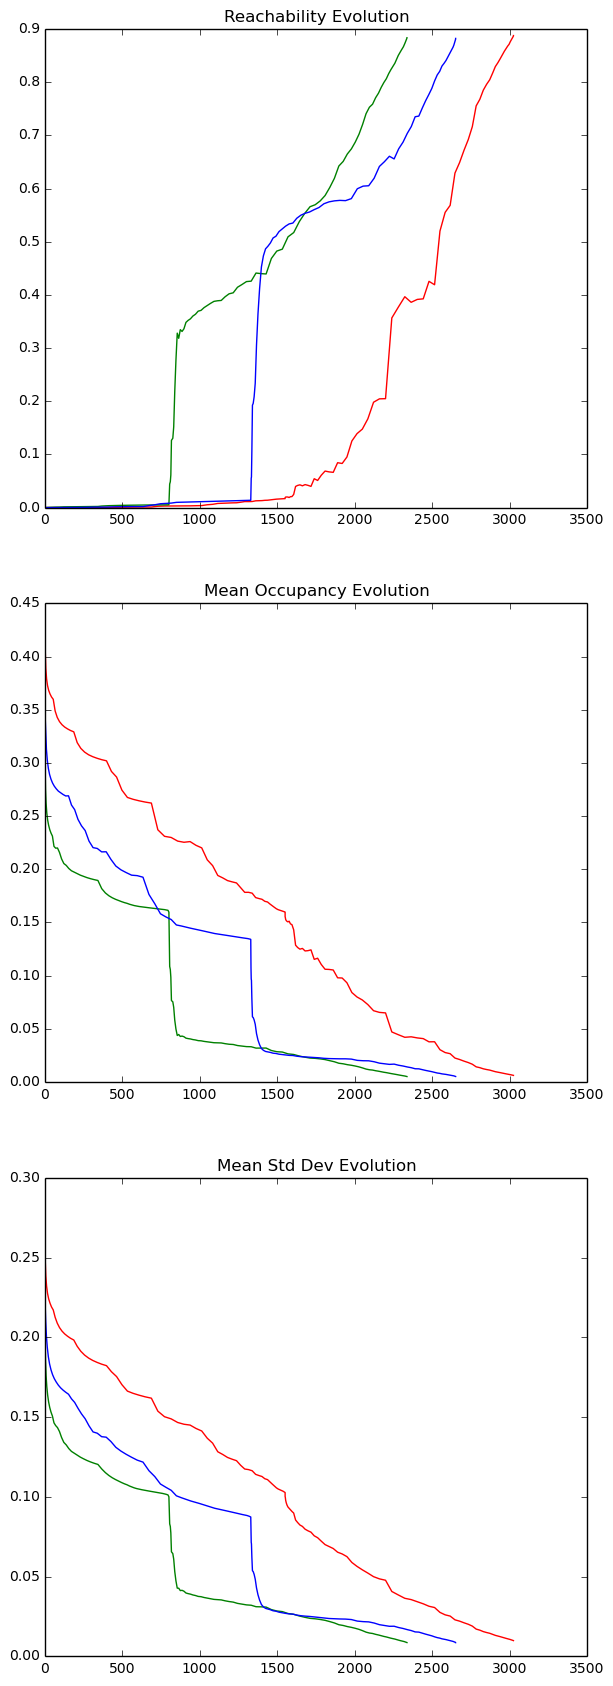

In [679]:
%matplotlib inline
plt.figure(figsize=(7,21))
sub = plt.subplot(311)
sub.set_title("Reachability Evolution")
for i, spline in enumerate(splines):
    reachabilityBelief = np.array(spline.trajectoryOccupanciesBelief)
    reachabilityBelief = reachabilityBelief.reshape(-1, spline.trajectoryVoxels)
    ones = np.ones(reachabilityBelief.shape)
    reachabilityBelief = ones - reachabilityBelief
    reachabilityBelief = np.prod(reachabilityBelief, axis=1)
    
    sub.plot(spline.trajectoryTime, reachabilityBelief, label=beliefName, c=colors[i%len(colors)])
    #plt.plot(spline.errorEvolutionLogOdds, label=logOddsName, linestyle='dashed', c=colors[i%len(colors)])
#plt.legend()

sub = plt.subplot(312)
sub.set_title("Mean Occupancy Evolution")
for i, spline in enumerate(splines):
    mean = np.array(spline.trajectoryOccupanciesBelief)
    mean = mean.reshape(-1, spline.trajectoryVoxels)    
    
    sub.plot(spline.trajectoryTime, np.mean(mean, axis=1), label=beliefName, c=colors[i%len(colors)])
    
sub = plt.subplot(313)
sub.set_title("Mean Std Dev Evolution")
for i, spline in enumerate(splines):
    stddev = np.array(spline.trajectoryStdDevsBelief)
    stddev = stddev.reshape(-1, spline.trajectoryVoxels)    
    
    sub.plot(spline.trajectoryTime, np.mean(stddev, axis=1), label=beliefName, c=colors[i%len(colors)])

# Cost Function $\mu \cdot \sigma$

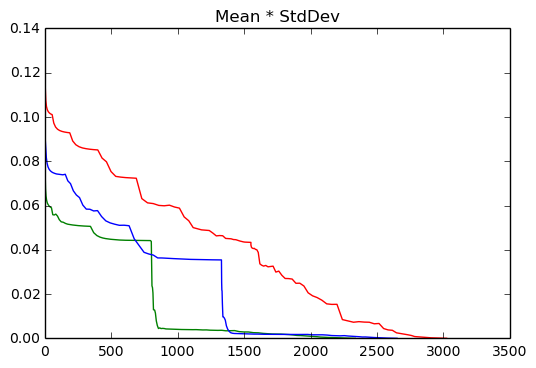

In [680]:
%matplotlib inline
plt.title("Mean * StdDev")
for i, spline in enumerate(splines):
    mean = np.array(spline.trajectoryOccupanciesBelief)
    mean = mean.reshape(-1, spline.trajectoryVoxels)
    stddev = np.array(spline.trajectoryStdDevsBelief)
    stddev = stddev.reshape(-1, spline.trajectoryVoxels)
    cost = np.multiply(mean, stddev)
    cost = np.mean(cost, axis=1)   
    
    
    plt.plot(spline.trajectoryTime, cost, label=beliefName, c=colors[i%len(colors)])

# Cost Function $\frac{\mu}{\sigma^2}$

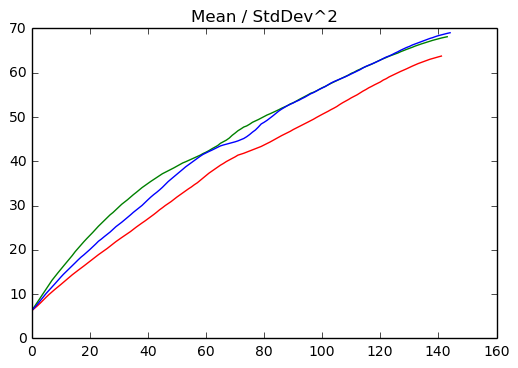

In [681]:
%matplotlib inline
plt.title("Mean / StdDev^2")
for i, spline in enumerate(splines):
    mean = np.array(spline.trajectoryOccupanciesBelief)
    mean = mean.reshape(-1, spline.trajectoryVoxels)
    stddev = np.array(spline.trajectoryStdDevsBelief)
    stddev = stddev.reshape(-1, spline.trajectoryVoxels)
    cost = np.divide(mean, np.square(stddev))
    cost = np.mean(cost, axis=1)   
    
    
    plt.plot(cost, label=beliefName, c=colors[i%len(colors)])

# Cost Function $\frac{1-\mu}{\sigma^2}$

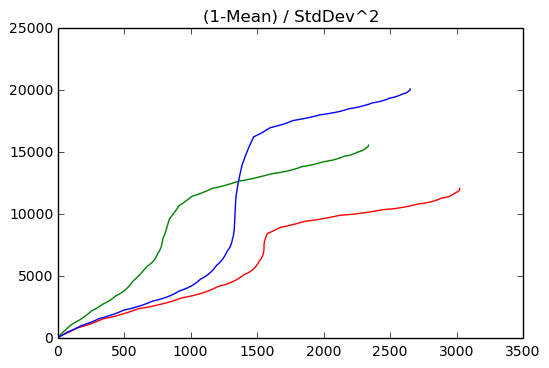

In [682]:
%matplotlib inline
plt.title("(1-Mean) / StdDev^2")
for i, spline in enumerate(splines):
    mean = np.array(spline.trajectoryOccupanciesBelief)
    mean = mean.reshape(-1, spline.trajectoryVoxels)
    stddev = np.array(spline.trajectoryStdDevsBelief)
    stddev = stddev.reshape(-1, spline.trajectoryVoxels)
    cost = np.divide(1-mean, np.square(stddev))
    cost = np.mean(cost, axis=1)   
    
    
    plt.plot(spline.trajectoryTime, cost, label=beliefName, c=colors[i%len(colors)])

# Spline Profile
The following plots show the 3 dimensions for the 3 splines: dimensions x and y for position, as well as the current yaw angle (2d robot orientation).

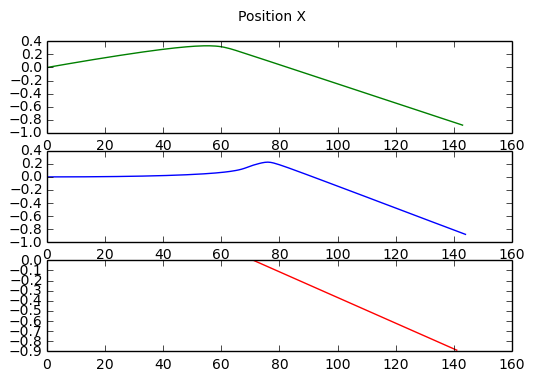

In [683]:
%matplotlib inline
plt.suptitle("Position X")
#self.axis_fullError.set_title('Mean Absolute Error (MAE) Evolution over all Voxels')
for i, spline in enumerate(splines):
    plt.subplot(3, 1, i)
    plt.plot(spline.trajectoryX, c=colors[i%len(colors)])  

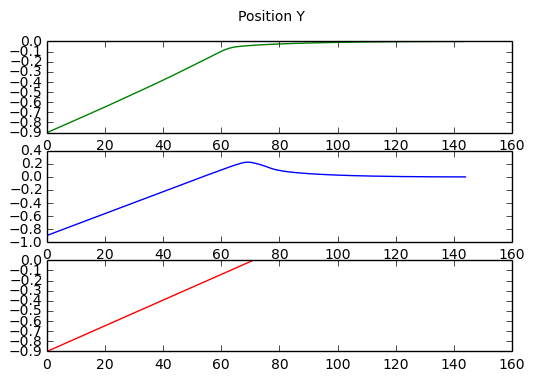

In [684]:
%matplotlib inline
plt.suptitle("Position Y")
#self.axis_fullError.set_title('Mean Absolute Error (MAE) Evolution over all Voxels')
for i, spline in enumerate(splines):
    plt.subplot(3, 1, i)
    plt.plot(spline.trajectoryY, c=colors[i%len(colors)])  

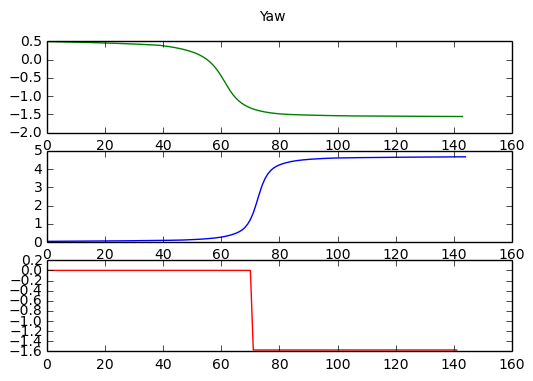

In [685]:
%matplotlib inline
plt.suptitle("Yaw")
#self.axis_fullError.set_title('Mean Absolute Error (MAE) Evolution over all Voxels')
for i, spline in enumerate(splines):
    plt.subplot(3, 1, i)
    plt.plot(spline.trajectoryT, c=colors[i%len(colors)])

# Velocity & Time Profiles
To generate trajectories from these splines, we need a velocity profile that follows the kinematic constraints of a robot, which are here maximum velocity, maximum acceleration and maximum centripetal acceleration.

The velocity profile is generated using a numerical method as described in section 3.2 of [Sprunk 2008](http://www2.informatik.uni-freiburg.de/~lau/students/Sprunk2008.pdf).

In [716]:
%matplotlib inline
import math

# Linear Interpolation
def time_to_step(array, time):
    if math.ceil(time) >= len(array):
        return array[-1]
    if time <= 0:
        return array[0]
    
    frac = time - math.floor(time)
    return (1.-frac) * array[int(math.floor(time))] + frac * array[int(math.ceil(time))]


# generate planning points with equidistant arc length
TOTAL_PLANNING_POINTS = 150

def velocity_profile(spline, array, ax=None, min_velocity=0.01, max_velocity=0.1, acceleration=0.4, start_velocity=0, end_velocity=0):
    # planning points in x/y position
    total_arc_length = 0.
    fine_step = 0.1
    last = array[0]
    empirical_max_velocity = 0
    for s in np.arange(fine_step, len(array), fine_step):
        x = time_to_step(array, s)
        total_arc_length += math.sqrt(((x-last)*1.) ** 2 + (fine_step) ** 2)
        empirical_max_velocity = max(empirical_max_velocity, abs(x-last))
        last = x
    print "Total arc length:", total_arc_length
        
    first_derivative = [0]
    last = array[0]
    max_first_derivative = 0.
    for s in np.arange(fine_step, len(array), fine_step):
        x = time_to_step(array, s)
        first_derivative.append(abs(x-last)/fine_step)
        max_first_derivative = max(max_first_derivative, first_derivative[-1])
        last = x
        
    #ax.plot(first_derivative)
        
    second_derivative = [0]
    last = first_derivative[0]
    max_second_derivative = 0.
    for s in np.arange(fine_step, len(array), fine_step):
        x = first_derivative[int(s/fine_step)]
        second_derivative.append(abs(x-last)/fine_step)
        max_second_derivative = max(max_second_derivative, second_derivative[-1])
        last = x
    
    #ax.plot(second_derivative)
    
    curvature = []
    for first, second in zip(first_derivative, second_derivative):
        curvature.append(abs(second)/(1.+first**2)**(3./2.))
    
    #plt.plot(first_derivative)
    #plt.plot(second_derivative)
    #print curvature
    #ax.plot(curvature)

    # arc length between equidistant planning points
    delta_s = total_arc_length / TOTAL_PLANNING_POINTS

    # compute equidistant planning points
    planning_points = []
    arc_length = 0.
    current_arc = 0.
    last = array[0]
    planning_points.append([array[0], current_arc, start_velocity])
    i = 4
    for s in np.arange(fine_step, len(array), fine_step):
        x = time_to_step(array, s)
        d = math.sqrt(((x-last)*1.) ** 2 + (fine_step) ** 2)
        arc_length += d
        current_arc += d
        if arc_length >= delta_s:
            # scale velocity such that empirical max velocity is desired max
            max_rot_vel = 5e-3
            
            max_curvature = 0
            for d in range(max(0,int(i)-4), min(len(curvature),int(i)+4)):
                max_curvature = max(curvature[d], max_curvature)
#             if max_curvature > 0:
#                 print max_curvature
            velocity = min(max_velocity, max_rot_vel/max_curvature) if max_curvature > 0 else max_velocity
            velocity = max(velocity, min_velocity)
            
            if max_curvature > 10:
                velocity = 0 # only spline 0 is affected here
            
            planning_points.append([x, current_arc, velocity])
            arc_length = 0.
        
        i += 1
        if i >= len(curvature):
            break
        last = x
    
    planning_points.append([array[-1], current_arc, end_velocity])

    arcs = list(map(lambda p: p[1], planning_points))
    velocities = list(map(lambda p: p[2], planning_points))
    if ax is not None:
        ax.scatter(arcs, velocities, label="initial", c="black")

    # update velocities (forward pass)
    v = start_velocity
    for i, (p, nextp) in enumerate(zip(planning_points, planning_points[1:])):
        p[2] = min(p[2], v)
        planning_points[i][2] = p[2]
        vs = []
        ss = []
        if nextp[1] == p[1]:
            continue
        for s in np.arange(0, nextp[1]-p[1], (nextp[1]-p[1])/20.):
            v = p[2] + acceleration * s
            vs.append(v)
            ss.append(p[1] + s)
        if ax is not None:
            ax.plot(ss, vs, c="r")

    # update velocities (backward pass)
    v = end_velocity
    for i in range(1, len(planning_points)):
        p = planning_points[-i]
        nextp = planning_points[-i-1]
        p[2] = min(p[2], v)
        planning_points[-i][2] = p[2]
        vs = []
        ss = []
        if nextp[1] == p[1]:
            continue
        for s in np.arange(0, nextp[1]-p[1], (nextp[1]-p[1])/20.):
            v = p[2] - acceleration * s
            vs.append(v)
            ss.append(p[1] + s)
        if ax is not None:
            ax.plot(ss, vs, c="b")


    arcs = list(map(lambda p: p[1], planning_points))
    velocities = list(map(lambda p: p[2], planning_points))
    if ax is not None:
        ax.scatter(arcs, velocities, label="initial", c="y")
        ax.plot(arcs, velocities, c="black", linestyle="dashed")
        ax.set_xlabel("Arc Length")
        ax.set_ylabel("Velocity")
    return planning_points

def plot_spline(spline_id):
    f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, sharex='col', figsize=(10,8))
    f.suptitle("Spline %i" % spline_id)
    print "Spline", spline_id
    print "Position X"
    velocity_profile(splines[spline_id], splines[spline_id].trajectoryX, ax1, acceleration=0.02)
    print "Position Y"
    velocity_profile(splines[spline_id], splines[spline_id].trajectoryY, ax3, acceleration=0.02)
    print "Position Z"
    velocity_profile(splines[spline_id], splines[spline_id].trajectoryT, ax5, acceleration=0.02)
    ax2.plot(splines[spline_id].trajectoryX, c=colors[spline_id%len(colors)])
    ax2.set_ylabel("Position X")
    ax4.plot(splines[spline_id].trajectoryY, c=colors[spline_id%len(colors)])
    ax4.set_ylabel("Position Y")
    ax6.plot(splines[spline_id].trajectoryT, c=colors[spline_id%len(colors)])
    ax6.set_ylabel("Yaw Angle")

Spline 0
Position X
Total arc length: 142.905565114
Position Y
Total arc length: 142.90564598
Position Z
Total arc length: 143.762095889


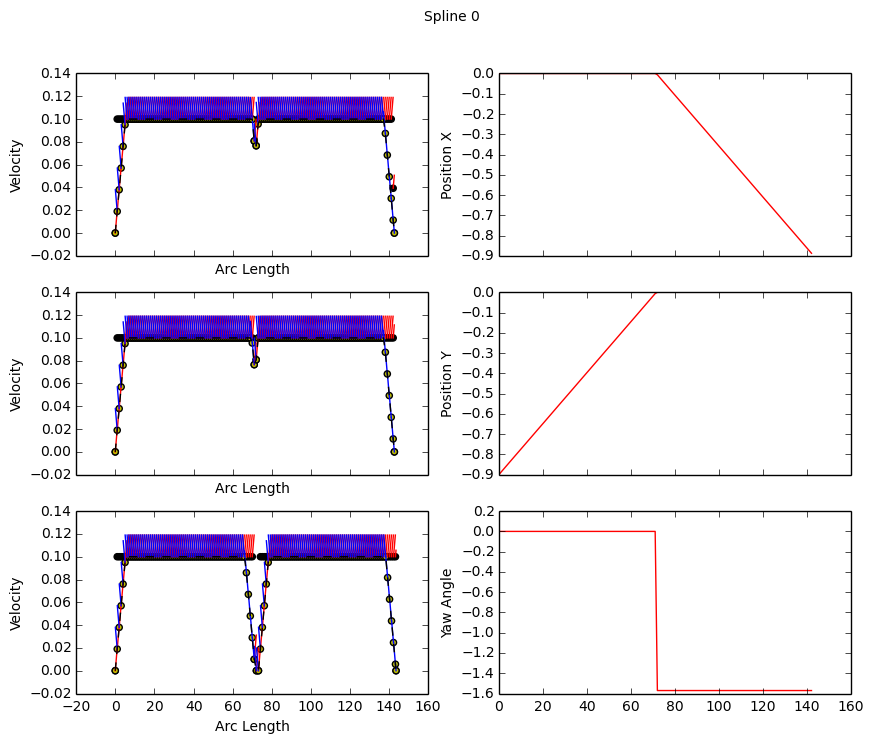

In [717]:
plot_spline(0)

In [688]:
import csv
def time_profile(spline_id):
    file_name = "timing_%i.csv" % spline_id
    f = open(file_name, "w")
    array = splines[spline_id].trajectoryT
    planning_points = velocity_profile(splines[spline_id], array, acceleration=0.008, max_velocity=5.)
    total_arc_length = 0.
    velocities = list(map(lambda p: p[2], planning_points))

    total_time = 0.
    relative_total_time = 0
    for p, lastp in zip(planning_points[1:], planning_points):
        for s in np.arange(0, 1, 1):
            delta_s = (p[1] - lastp[1]) * 1
            #delta_t = 2 * delta_s / (p[2] + lastp[2])
            if p[2] == lastp[2]:
                continue
            delta_t = (2 * delta_s / (p[2] + lastp[2]))
            total_time += delta_t
            relative_total_time += p[2] * s + lastp[2] * (1-s)

    print "Total time:", total_time
    times = []
    trajectory = []
    time = 0.

    def arc_to_step(array, arc):
        arc_length = 0.cp
        last = array[0]
        for s in np.arange(0.01, len(array), 0.01):
            x = time_to_step(array, s)
            d = math.sqrt(((x-last)*10.) ** 2 + (0.01) ** 2)
            arc_length += d
            if arc_length >= arc:
                return x
            last = x

    arc = 0
    total_arc = planning_points[-1][1]
    for p, lastp in zip(planning_points[1:], planning_points):
        for s in np.arange(0, 1, 1):
            delta_s = (p[1] - lastp[1]) * 1
            arc += delta_s
            #delta_t = 2 * delta_s / (p[2] + lastp[2])
            delta_t = (p[2] * s + lastp[2] * (1-s))
            time += delta_t
            t = time/relative_total_time * total_time
            times.append(t)
            f.write("%f\n" % t)
            #trajectory.append(arc_to_step(array, arc))
            trajectory.append(time_to_step(array, arc/total_arc * len(array)))
            #trajectory.append(time_to_step(array, time/total_time * len(array)))
            #trajectory.append(time_to_step(array, time/total_time * total_arc))
       
    f.close()
    print "Saved trajectory timing to %s." % file_name
    ax = plt.subplot(111)
    ax.scatter(times, trajectory, s=0.1)
    ax.scatter(times, [-2]*len(times), s=0.1, edgecolor="b")
    ax.set_xlabel("Time")
    ax.set_ylabel("Yaw")
    return times

Total arc length: 143.762095889
Total time: 3031.72283598
Saved trajectory timing to timing_0.csv.


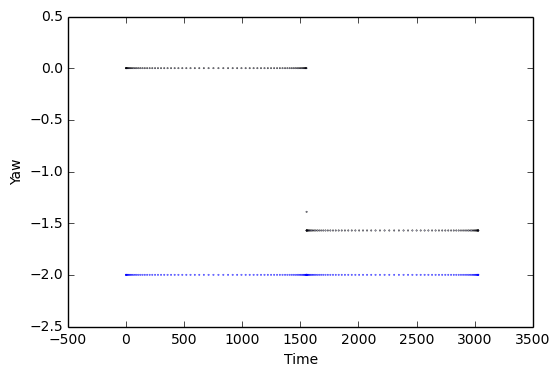

In [718]:
_ = time_profile(0)

In this plot, the dots follow the above spline for the yaw angle. They are spaced according to the time profile such that more dense points represent slower movement, while the change of yaw angle in the middle of this trajectory happens abruptly. The one-dimensional time profile is plotted separately below in blue.

Spline 1
Position X
Total arc length: 143.909893392
Position Y
Total arc length: 143.905635186
Position Z
Total arc length: 143.974213863


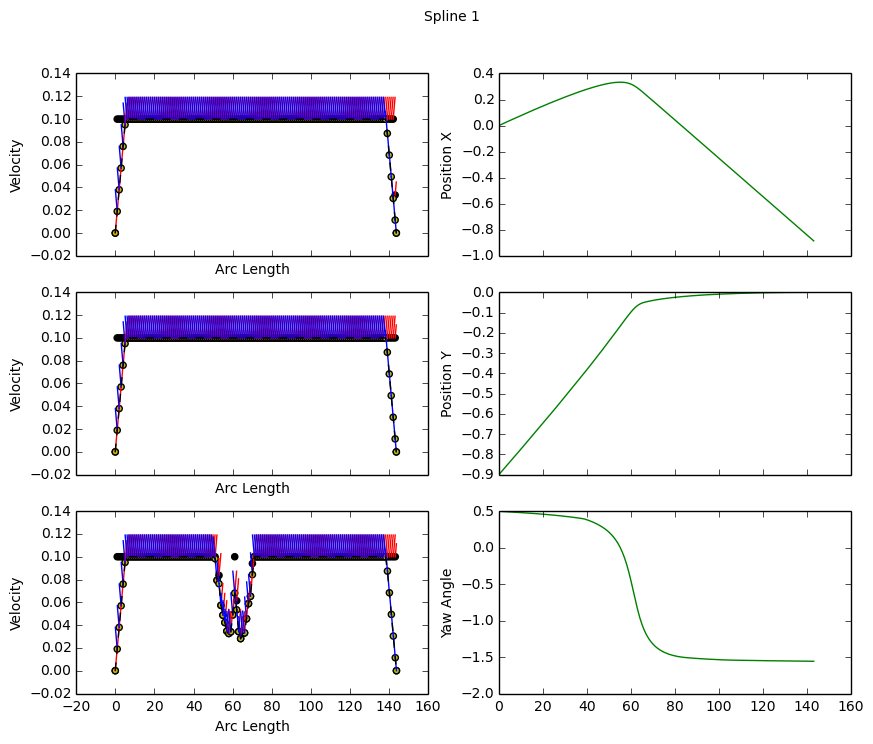

In [719]:
plot_spline(1)

Note how the green spline can be followed at maximum velocity throughout the phase between initial acceleration and final deceleration. Therefore, this trajectory is the fastest possible for the defined kinodynamic constraints.

Total arc length: 143.974213863
Total time: 2337.29213008
Saved trajectory timing to timing_1.csv.


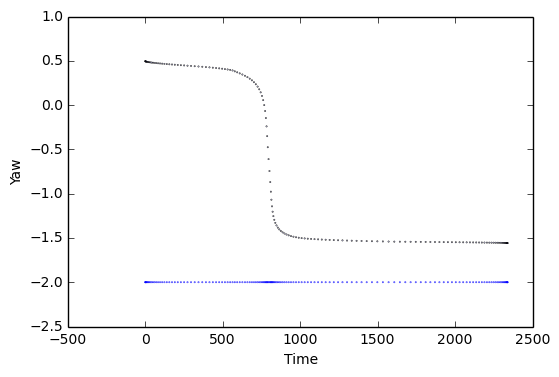

In [720]:
_ = time_profile(1)

Spline 2
Position X
Total arc length: 145.910102747
Position Y
Total arc length: 145.910237985
Position Z
Total arc length: 151.378517118


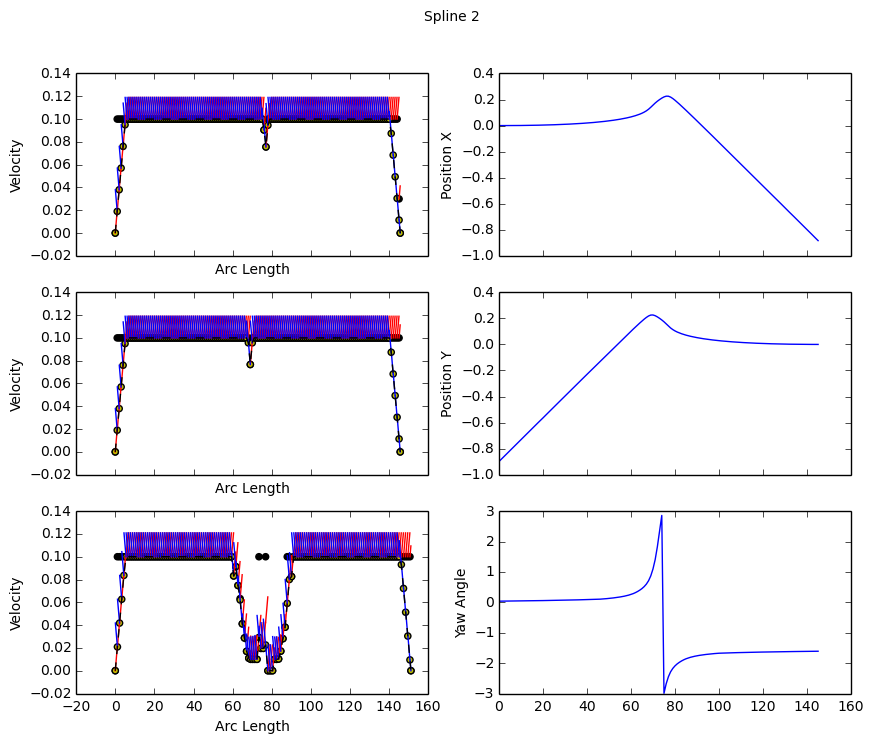

In [721]:
plot_spline(2)

Total arc length: 151.378517118
Total time: 3505.65211397
Saved trajectory timing to timing_2.csv.


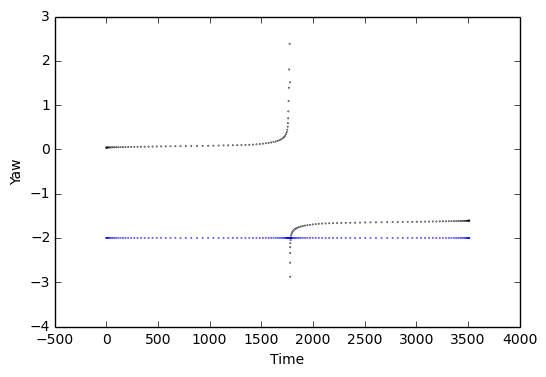

In [722]:
_ = time_profile(2)